In [1]:
%matplotlib inline 
import numpy as np
import random
import matplotlib.pyplot as plt
from random import choices
import celerite
from celerite import terms
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interp1d
import scipy

from ipywidgets import Layout, interact, fixed, interactive
import ipywidgets as widgets

from torus_model import *

import plotly
import plotly.graph_objs as go
import plotly.io as pio
import plotly.offline as pyo
pio.renderers.default = 'notebook'
%config InlineBackend.figure_format='retina'

### Introduction

This notebook contains example codes used to generate the transfer functions, light curves and structure functions (SFs) from a given optical variability pattern and torus geometry.

We simulate idealized light curve in the optical from a DRW model and convolve with the torus transfer function to obtain the MIR light curve. The model SF is then derived from N ensembles of the idealized light curves to reduce statistical noise. The SF of individual light curve is defined as 

\begin{equation}
{\rm SF}(\Delta t) = \sqrt{\frac{1}{N_{\Delta \rm t, pairs}} \sum_{i=1}^{N_{\rm \Delta t, pairs}}\Delta f^2} \equiv \sqrt{\Delta F},
\label{eq:sf}
\end{equation}
where $\Delta f$ is the flux difference between two epochs separated by $\Delta t$ (in the rest-frame) after subtracting the photometric noise $\sigma_f$ as
\begin{equation}
\Delta f^2  = (f(t) - f(t+\Delta t))^2 - \sigma_f (t)^2 - \sigma_f (t + \Delta t)^2.
\end{equation}
For simulated idealized light curves, we do not need to subtract the noise term. 

In principle, the ensemble SF is calculated from the average of each individual SF derived from Eq. \ref{eq:sf} (i.e., first apply sqrt to $\Delta F$ then derive an average). However, observationally, the noise subtraction process may result in a negative $\Delta F$. Therefore, we first derive an average $\Delta F$ then apply sqrt. The former and latter methods are named as sqrt_mean and mean_sqrt, respetively.


The shape of the ensemble SF can be expressed as
\begin{equation}
    {\rm SF}(\Delta t) = {\rm SF}_\infty \sqrt{1 - e^{-(|\Delta t|/\tau)^{\beta}}},
\end{equation}

Here we decribe each model parameters.

optical DRW parameters
* tau_g: dampint timescale $\tau$ in days
* SFinf_g: structure function infinity
* sigma_g: rms variability of the light curve. sigma_g = SFinf_g/$\sqrt 2$
* beta: short-timescale powerlaw slope of the SF; beta=1.0 for a DRW process
* flux_mean: mean flux of the light curve


torus geometrical parameters
* incl: inclination angle in degree (0-90)
* Rin: inner radius in pc
* sigma: half-opening angle in degree (0-90)
* Y: outer to inner radius ratio (> 1). Note that our model is only valid for small values of Y, i.e., we are probing the torus at a given wavelength. 
* p: radial powerlaw index (default -1.0)
* amp: MIR/optical flux ratio (default 1.0)
* ncloud: cloud number (default 100000)

light curve parameters
* cadence: cadence of the simulated light curve in days (default 5)
* dt: time interval used to construct the transfer function in days (default 1.0). For a large torus (e.g., Rin > 0.1 pc), dt = 1.0 is usually sufficient; while for a compact torus (e.g., Rin = 0.01 pc), the centroid of the transfer function is only a few days, thus a small value of dt (e.g., 0.1) is suggested.
* initial_length: initial length of the MIR light curve in days (default 10000); the actual length of the returned light curve is determined by initial_length/cadence

ensemble parameters
* ensemble_num: number of ensembles to derive the structure function (default 100). A large number is required to reduce statistical noise
* ensemblue_method: method used to derive the ensemble structure function, can be 'mean_sqrt' (default) or 'sqrt_mean'

### 3D torus structure

In [3]:
# 3D torus structure (Figure 2 in the paper)
# Each cloud is color-coded by the time delay relative to the observer's line of sight

incl = 45
Rin = 0.5
sigma = 30
Y = 1.5
p = -1.0

delay_t, delay_phi, R_random, beta_random, phi_random, delay = simulate_transfer_func(incl=incl, 
                                                                        Rin=Rin, sigma=sigma, Y=Y, p=p, 
                                                                        ncloud=3000, 
                                                                        return_data=True, 
                                                                        return_cloud=True,
                                                                        show_plot=False)

x = R_random * np.cos(beta_random) * np.cos(phi_random)
y = R_random * np.cos(beta_random) * np.sin(phi_random)
z = R_random * np.sin(beta_random)

plt.figure(figsize=(3, 3))

# Configure the trace.
trace = go.Scatter3d(
        x=x,  
        y=y,  
        z=z,  
        mode='markers',
        marker={
            'size': 1,
            'opacity': 1,
            'color': delay, 
            'colorbar': dict(thickness=20, orientation='v', x=0.9, len=1.0, y=0.48, title=r'days'),
            'colorscale':'rdylgn'
        },
    )


fig = go.Figure(data=[trace])
  
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
        scene = dict(
                     xaxis = dict(nticks=5, range=[-Rin*Y*1.1, Rin*Y*1.1], title=r"x (pc)"),
                     yaxis = dict(nticks=5, range=[-Rin*Y*1.1, Rin*Y*1.1], title=r'y (pc)'),
                     zaxis = dict(nticks=5, range=[-Rin*Y*1.1, Rin*Y*1.1], title=r'z (pc)'),),
        width=600, height=500
        )

pyo.iplot(fig)

<Figure size 300x300 with 0 Axes>

### Dependence of transfer function on torus geometry

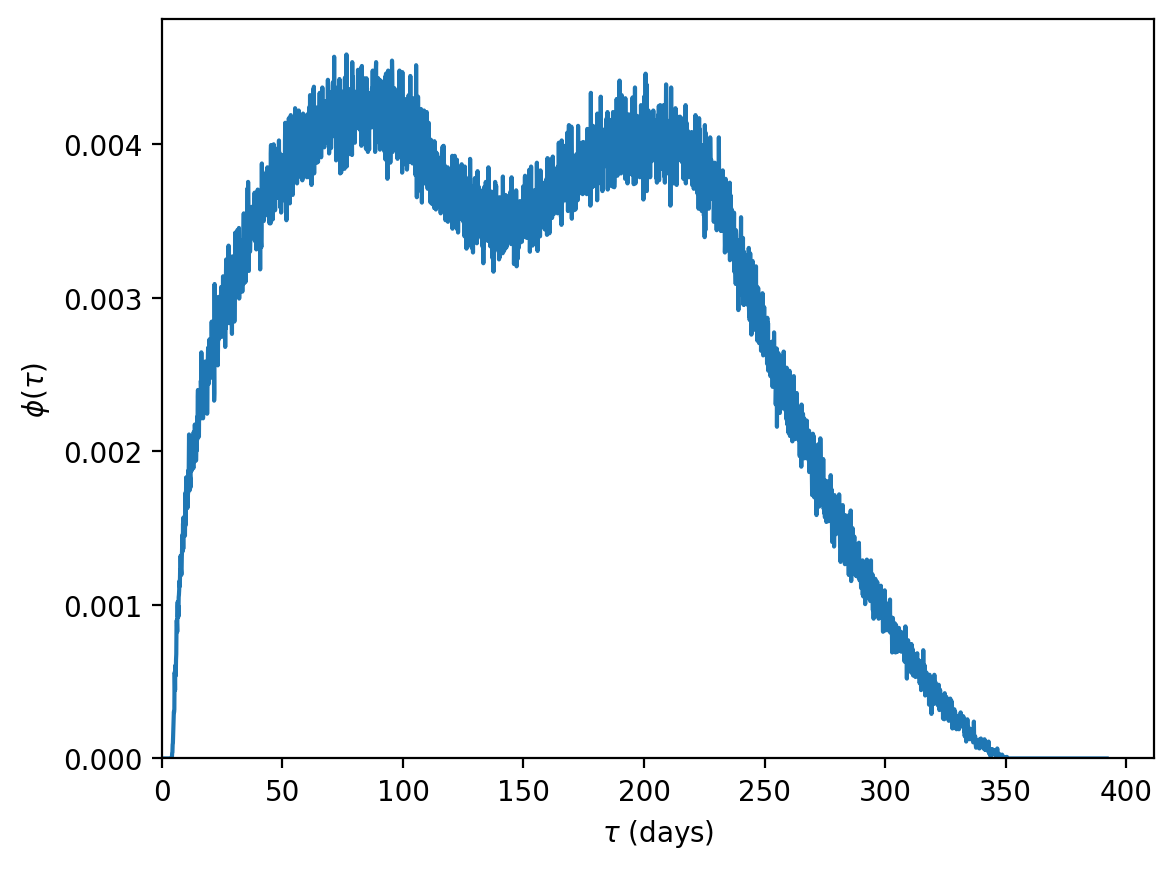

In [3]:
delay_t, delay_phi = simulate_transfer_func(incl=45, Rin=0.1, sigma=30, ncloud=1000000, return_data=True, show_plot=True)

In [4]:
interactive(simulate_transfer_func, 
         incl=widgets.IntSlider(min=0, max=90, value=30, step=1, layout=Layout(width='800px')),
         Rin=widgets.FloatSlider(min=0.001, max=1.0, value=0.3, step=0.01, layout=Layout(width='800px')),
         sigma=widgets.IntSlider(min=10, max=60, value=30, step=1, layout=Layout(width='800px')),
         Y=widgets.FloatSlider(min=1.0, max=10.0, value=1.5, step=0.1, layout=Layout(width='800px')),
         p=widgets.FloatSlider(min=-3.0, max=0.0, value=-1.0, step=0.1, layout=Layout(width='800px')),
         ncloud=widgets.IntSlider(min=10000, max=500000, value=100000, step=50000, layout=Layout(width='800px')),
         dt=widgets.FloatSlider(min=0.01, max=5.0, value=1.0, step=0.1, layout=Layout(width='800px')),
         return_data=fixed(False), show_plot=fixed(True), return_cloud=fixed(False), seed=fixed(1)
        )

interactive(children=(IntSlider(value=30, description='incl', layout=Layout(width='800px'), max=90), FloatSlid…

###  Idealized light curves and model structure functions

In [5]:
# optical DRW parameters
tau_g = 650 
SFinf_g = 0.1 
sigma_g = SFinf_g / np.sqrt(2.0) 
beta = 1.0 
flux_mean = 1.0 

# torus geometry
incl = 30 
Rin = 0.3
sigma = 30 
Y = 1.5 
p = -1.0 
amp = 1.0 
ncloud = 100000 

# light curve
cadence = 5 
dt = 1.0
initial_length = 10000 

# ensemble
ensemble_num = 100 
ensemblue_method = 'mean_sqrt' 

Text(0.5, 1.0, '$\\tau$=650.0, incl=30.0, Rin=0.30, sigma=30.0')

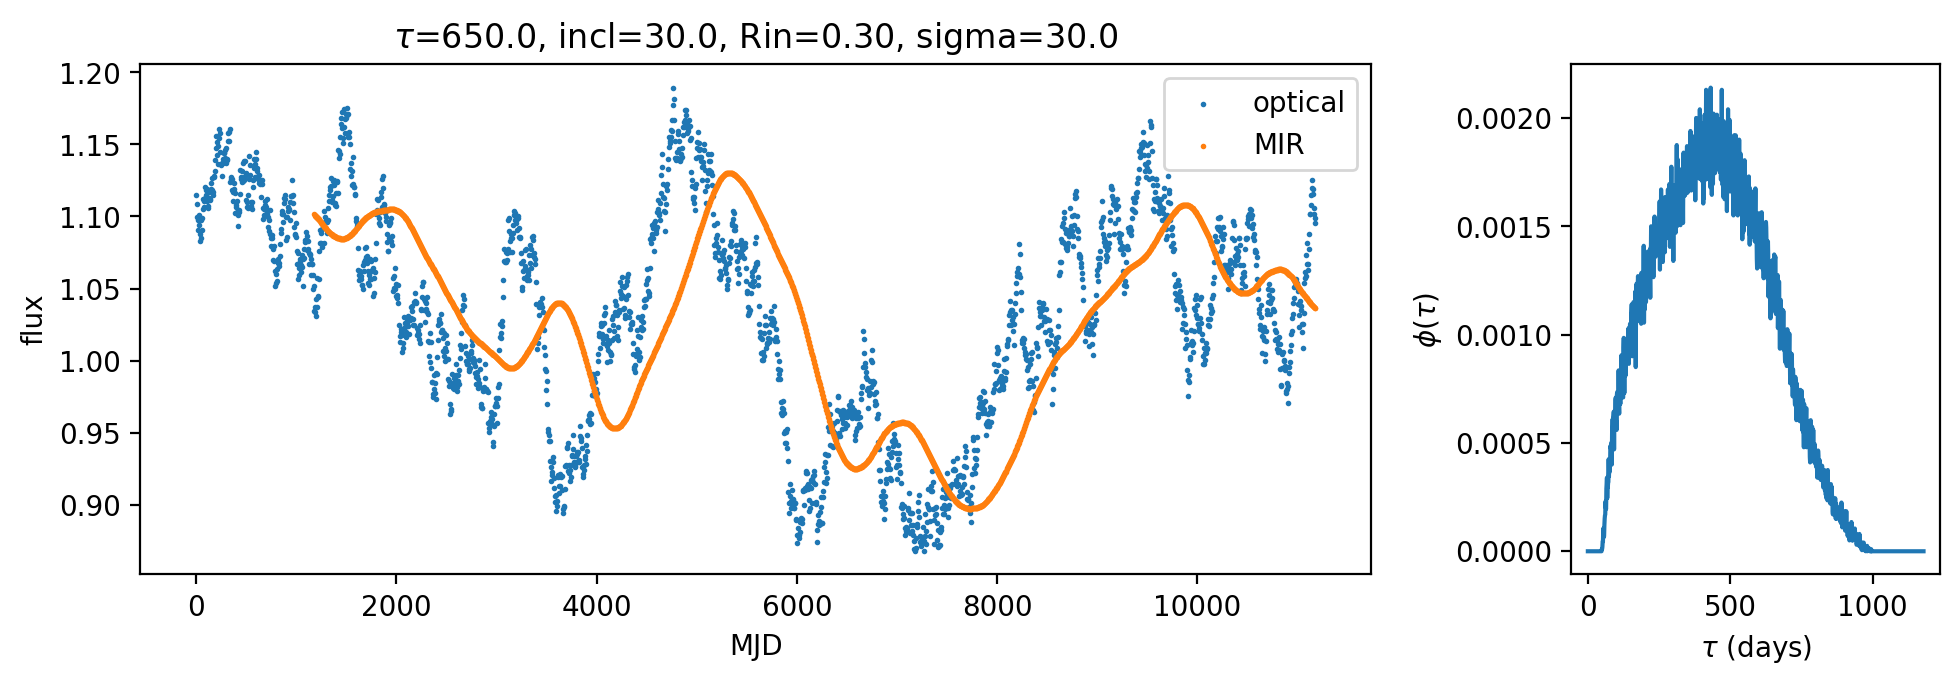

In [10]:
# plot a realization of the simulated light curve
gridspec_kwargs = dict(top=0.95, bottom=0.1, left=0.08, right=0.98, wspace=0.25, width_ratios=[1, 0.3])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10., 3.0), gridspec_kw=gridspec_kwargs)
ax1, ax2 = ax[0], ax[1]

flux_g, mjd_g, flux_w, mjd_w = simulate_perfect_light_curve(
                                     tau_g=tau_g, 
                                     sigma_g=sigma_g, 
                                     flux_mean=flux_mean, 
                                     incl=incl, 
                                     Rin=Rin, 
                                     sigma=sigma, 
                                     Y=Y, 
                                     p=p,
                                     amp=amp,
                                     ncloud=ncloud, dt=dt,
                                     initial_length=initial_length, cadence=cadence,
                                     seed=1)


ax1.scatter(mjd_g, flux_g, s=1, label='optical')
ax1.scatter(mjd_w, flux_w, s=1, label='MIR')

ax1.legend()
ax1.set_xlabel('MJD')
ax1.set_ylabel('flux')

# transfer function
delay_t, delay_phi = simulate_transfer_func(incl, Rin, sigma, Y, p, ncloud, dt, True)

ax2.plot(delay_t, delay_phi)
ax2.set_xlabel(r'$\tau$ (days)')
ax2.set_ylabel(r'$\phi(\tau)$')

ax1.set_title(r'$\tau$={:.1f}, incl={:.1f}, Rin={:.2f}, sigma={:.1f}'.format(tau_g, incl, Rin, sigma))

In [6]:
# derive the model SF from N ensembles of idealized light curves
sf_params = model_sf(tau_g=tau_g, sigma_g=sigma_g, flux_mean=flux_mean, 
                     incl=incl, Rin=Rin, sigma=sigma, Y=Y, p=p, amp=amp, ncloud=ncloud, dt=dt,
                     initial_length=initial_length, cadence=cadence, ensemble_num=ensemble_num,
                     ensemblue_method=ensemblue_method)

Start...
ensemble 20...
ensemble 40...
ensemble 60...
ensemble 80...
ensemble 100... Done


Text(0.5, 1.0, '$\\tau$=650.0, incl=30.0, Rin=0.30, sigma=30.0')

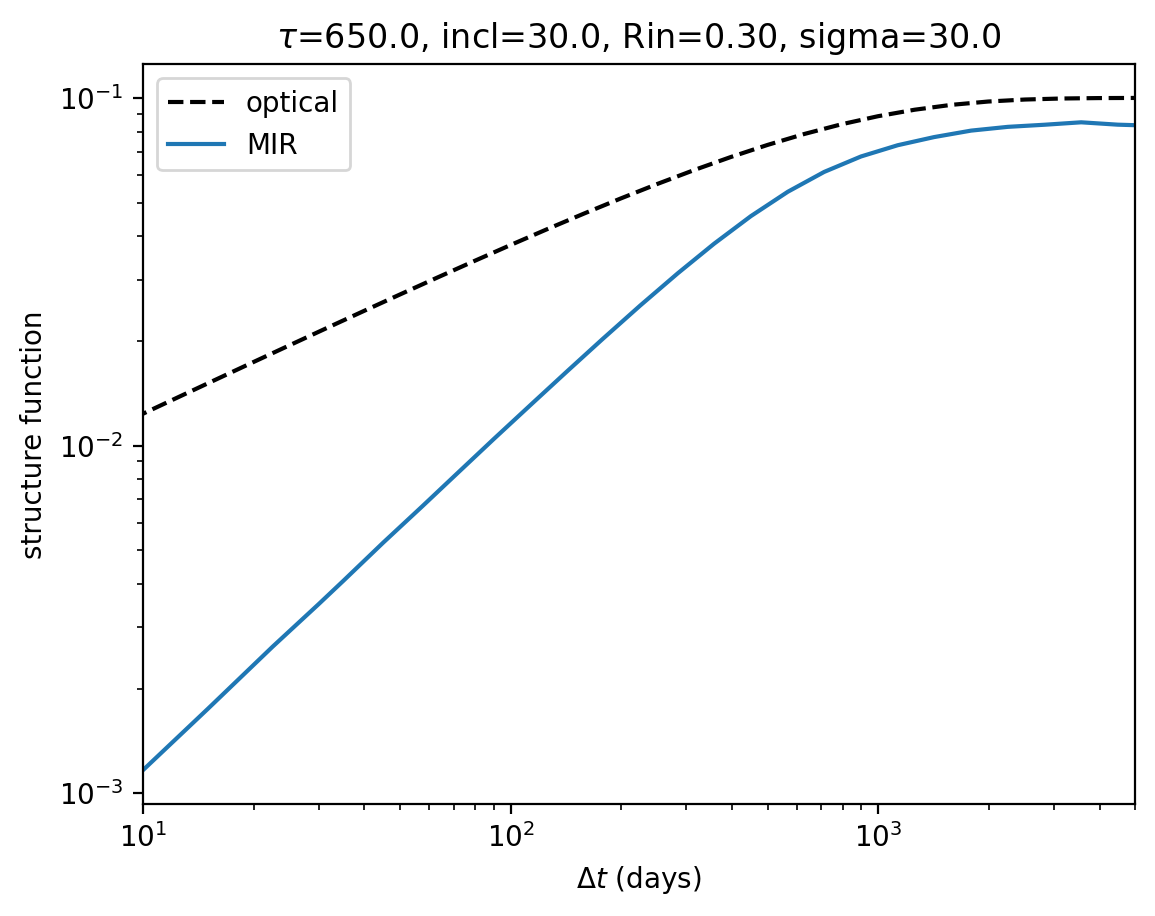

In [7]:
# plot optical and MIR SFs
delta_t = 10**np.arange(np.log10(5.0), np.log10(5000)+0.1, 0.1) 
sf_g_model = sf_analytic(delta_t, SFinf_g, tau_g, beta)
plt.plot(delta_t, sf_g_model, 'k--', label='optical')

plt.plot(sf_params['lag_w'], sf_params['sf_w'], label='MIR')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Delta t$ (days)')
plt.ylabel('structure function')
plt.xlim(10, 5000)
plt.title(r'$\tau$={:.1f}, incl={:.1f}, Rin={:.2f}, sigma={:.1f}'.format(tau_g, incl, Rin, sigma))